In [1]:
import sys 
sys.path.append("./pocomc/")

import os
import time
import pickle
import roadrunner as rr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import qmc
from multiprocessing import Pool

import pocomc as pc


SEED = 1
np.random.seed(seed=SEED)

n_cpus = os.cpu_count() 
print('This machine has {} CPUs'.format(n_cpus))

This machine has 10 CPUs


In [2]:
class Model:
    def __init__(self, opts): #initial settings
        for key in opts: #loops for all labels in the list 'key'
            setattr(self, key, opts[key]) #creates a dictionary where 'key' are the list of labels & 'ops[key]' are the values
        # Default model output to times and experimental observables
        self.observables= list(self.data.columns)[1:]
        self.defaultOutput= ['time'] + self.observables
        self.n_params= len(self.params)
        self.n_obs= len(self.observables)

    def __call__(self, theta_new):
        theta_new = theta_new
        res = self.log_likelihood(theta_new)
        return res
    
    def run(self, params=None, x0=None, times=None, output=None):
        rr = self.rr
        rr.reset()
        rr.integrator.absolute_tolerance = 1e-12
        rr.integrator.relative_tolerance = 1e-12
        addZero=False

        # Use timepoints of data as default times at which to get sim output
        if params is None:
            params= self.p_true  
        if x0 is None:
            x0= self.x0
        if times is None:
            times= list(self.data['time'].values)
        # make sure zero is first time point
        if (times[0]>0.0):
            addZero= True
            times= [0] + times

        # Set default output are the column names of the data
        if output is None:
            output= self.defaultOutput
       
        # Set parameter values
        for name, value in zip(self.params, params):
            rr[name] = float(value)
        #rr.reset() # force update of parameter expression (POSSIBLY NOT NEEDED)

        # NOTE: If you want to vary the initial conditions, do this by defining a parameter in the model that sets the initial concentration of species and then include this parameter in your list of parameters to fit. 

        # Run trajectories
        try:
            traj = rr.simulate(times=times,selections=output)  
        except:
            # If integration fails return empty array
            return([])

        if (addZero):
            # Return traj with zero timepoint removed
            return(traj[1:,:])
        else:
            return(traj)
        
    def log_prior(self, theta_new): 
        bools = [(low <= i <= high) for i,low,high in zip(theta_new, self.lower_bnds, self.upper_bnds)] #if generated values are within bounds
        all_in_range = np.all(bools) #if all values are true, then output is true
        if all_in_range: 
            return 0.0 
        return -np.inf #if even one parameter out of bounds, it's false, and returns -infinity

    def log_likelihood(self, theta_new): #how good is this candidate parameter fitting my data (maximize it)
        params = theta_new[:self.n_params] 
        if self.fit_x0: 
            x0 = theta_new[self.n_params:(self.n_params + len(self.x_0))] #sets x0 to 'theta_true' x0 values
        else:
            x0 = self.x0
        y = self.run(params=params, x0=x0)[:,1:] #sets y to the y results of solving ODE
        if (len(y)==0):
            # return large (but not infinite value) if integration fails
            return(-1e11)
        if (np.any(np.isnan(y))):
            return(-1e12)

        if self.fit_sigma:
            sigma = theta_new[-len(self.observables):] #observable index related to sigma
        else:
            sigma = [1] * len(self.observables) #makes all sigmas default to 1

        obs = self.data.values[:,1:] #sets data

        # Calculate likelihood
        #term1 = 0 #-0.5 * np.log(2*np.pi*np.square(sigma))
        #term2 = sum (y-obsnp.square(np.subtract(y, obs)) / (2*np.square(sigma))
        #logLH = np.sum(term1 - term2)
        ll= -sum(((y-obs)/(sigma))**2)# chi^2
        return(ll[0])

Just varying the activation parameters 

In [3]:
mod_opts = {} 
# load data for model
mod_df = pd.read_csv('onePercNoise_NFkB_data.csv', header=0, delimiter=",") #reads in data file
mod_opts['data'] = mod_df
# Load in SBML model using libroadrunner
sbml_file = "myImplemt.xml"
mod_opts['rr'] = rr.RoadRunner(sbml_file)
mod_opts['params'] = ["LOG_k_b", "LOG_k_f", "LOG_k_a", "LOG_k_4", "LOG_k_i1", "LOG_k_e1", "LOG_k_t2a", "LOG_k_t1a"]#, "LOG_k_i2", "LOG_k_e2", "LOG_k_e2a", "LOG_c_4a", "LOG_c_5a", "LOG_c_1a", "LOG_k_a1a", "LOG_k_d1a", "LOG_c_3", "LOG_c_1", "LOG_k_ikk", "LOG_k_tnfr", "LOG_TNFRin", "LOG_IKKin", "LOG_boundc"] # names of parameters in order from bngl file 

# trying to only do some params 
# mod_opts['params'] = ["LOG_k_b", "LOG_k_f", "LOG_k_a", "LOG_k_4"] # names of parameters in order from bngl file 

# mod_opts["species"] = ["TNF", "TNFRi", "TNFRa", "IKKi", "IKKa", "cNFKB", "nNFKB", "cIkB", "nIkB", "cNFkB_IkB", "nNFkB_IkB", "A20"] # names of observables in order from bngl file, also in smbl under "dependent variables / observables"
mod_opts["species"] = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11", "S12"]
mod_opts['x0'] = [0,2.5258,0,4.7454,0,0,0,0,0,6.5546,0,0] # initial conditions (if given)

# ! TO DO: we currently assume it fit_x0, then ALL species initial conditions are fit
mod_opts['fit_x0'] = False # fit initial conditions?
mod_opts['fit_sigma'] = False #fit sigma?
mod_opts['p_true'] = [0.0352,-3.0688,-4.5164,-7.4173,-2.057,-5.9334,-8,-7.3178]#,-4.1089,-10.6289,-3.5859,-4.6363,-4.6,-3.2082,-7,-8,-20,-20,-20,-20,2.5258,4.7454,6.5546] #guess param values(in log)
# mod_opts['lower_bnds'] = [-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30,-30] #lower bounds(in log)
# mod_opts['upper_bnds'] = [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10] #upper bounds(in log)

# use these ones 
# mod_opts['lower_bnds'] = [-5,-5,-5,-10,-5,-10,-10,-10,-10,-20,-10,-10,-10,-10,-10,-10,-30,-30,-30,-30,-10,-10,-10] #lower bounds(in log)
# mod_opts['upper_bnds'] = [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,10,10] #upper bounds(in log)

mod_opts['lower_bnds'] = [0,-4,-5,-8,-3,-6,-9,-8]#,-5,-11,-4,-5,-5,-4,-8,-9,-21,-21,-21,-21,2,4,6] #lower bounds(in log)
mod_opts['upper_bnds'] = [1,-1,-3,-6,-1,-4,-7,-5]#,-3,-9,-3,-3,-3,-2,-6,-7,-19,-19,-19,-19,3,5,7] #upper bounds(in log)

mod_opts['lower_bnds'] = np.array(mod_opts['lower_bnds']).astype(float)
mod_opts['upper_bnds'] = np.array(mod_opts['upper_bnds']).astype(float)


model = Model(mod_opts)

In [4]:
print(mod_opts['lower_bnds'])
print(type(mod_opts['lower_bnds']))

print(mod_opts['upper_bnds'])
print(type(mod_opts['upper_bnds']))

[ 0. -4. -5. -8. -3. -6. -9. -8.]
<class 'numpy.ndarray'>
[ 1. -1. -3. -6. -1. -4. -7. -5.]
<class 'numpy.ndarray'>


In [5]:
# function to plot model fit 
def plot_fit(p):
    # simulates model with parameters over specific time frame
    ## traj has time and conentration 
    traj= model.run(params=p,times=np.linspace(0,300,101))
    # plots experimental data 
    plt.plot(model.data['time'].values,model.data['nNFkB'].values,'go',label='data')
    # plots model fit 
    plt.plot(traj[:,0],traj[:,1],'g-',label='fit')
    # log likelihood to calc cost of the fit 
    cost= model.log_likelihood(p)
    plt.title(f'Fit for $\chi^2=${-cost:0.2e}')
    _=plt.legend()

In [6]:
model.rr['LOG_k_b']=0 # sets parameters value to 0
model.rr.reset() # resets model to initial conditions 
print("TNF initial concentration:", np.log10(model.rr['init(S1)']))
print("TNFRi initial concentration:", np.log10(model.rr['init(S2)']))
print("TNFRa initial concentration:", np.log10(model.rr['init(S3)']))
print("IKKi initial concentration:", np.log10(model.rr['init(S4)']))
print("IKKa initial concentration:", np.log10(model.rr['init(S5)']))
print("NFkBc initial concentration:", np.log10(model.rr['init(S6)']))
print("NFkBn initial concentration:", np.log10(model.rr['init(S7)']))
print("IkBc initial concentration:", np.log10(model.rr['init(S8)']))
print("IkBn initial concentration:", np.log10(model.rr['init(S9)']))
print("nNFkBIkBc initial concentration:", np.log10(model.rr['init(S10)']))
print("nNFkBIkBn initial concentration:", np.log10(model.rr['init(S11)']))
print("A20 initial concentration:", np.log10(model.rr['init(S12)']))


TNF initial concentration: 0.6989700043360189
TNFRi initial concentration: 2.52580000394291
TNFRa initial concentration: -inf
IKKi initial concentration: 4.745400000099128
IKKa initial concentration: -inf
NFkBc initial concentration: -inf
NFkBn initial concentration: -inf
IkBc initial concentration: -inf
IkBn initial concentration: -inf
nNFkBIkBc initial concentration: 6.554600003006979
nNFkBIkBn initial concentration: -inf
A20 initial concentration: -inf


/var/folders/jy/c63ddq7x061bb11h5xt4r2jr0000gn/T/ipykernel_14282/2467364202.py:5: RuntimeWarning: divide by zero encountered in log10
  print("TNFRa initial concentration:", np.log10(model.rr['init(S3)']))
/var/folders/jy/c63ddq7x061bb11h5xt4r2jr0000gn/T/ipykernel_14282/2467364202.py:7: RuntimeWarning: divide by zero encountered in log10
  print("IKKa initial concentration:", np.log10(model.rr['init(S5)']))
/var/folders/jy/c63ddq7x061bb11h5xt4r2jr0000gn/T/ipykernel_14282/2467364202.py:8: RuntimeWarning: divide by zero encountered in log10
  print("NFkBc initial concentration:", np.log10(model.rr['init(S6)']))
/var/folders/jy/c63ddq7x061bb11h5xt4r2jr0000gn/T/ipykernel_14282/2467364202.py:9: RuntimeWarning: divide by zero encountered in log10
  print("NFkBn initial concentration:", np.log10(model.rr['init(S7)']))
/var/folders/jy/c63ddq7x061bb11h5xt4r2jr0000gn/T/ipykernel_14282/2467364202.py:10: RuntimeWarning: divide by zero encountered in log10
  print("IkBc initial concentration:", np.

0.0


Text(0.5, 1.0, 'nNFkB Concentration')

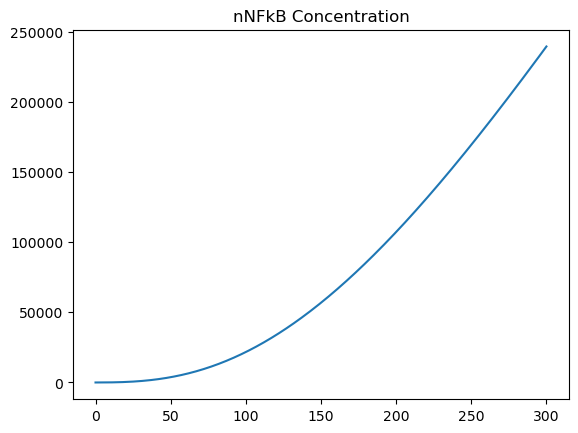

In [7]:
# runs model with given set of parameters, this can be changed []
# traj is array: rows are time, cols are concentraation
traj= model.run(params=model.p_true,times=np.linspace(0,300,301))
plt.plot(traj[:,0],traj[:,1]) # plots first observable (2nd col of traj) against time 
print(traj[0,1]) # prints initial condition of the first observable  
plt.title("nNFkB Concentration")

Text(0.5, 1.0, 'nNFkB Concentration')

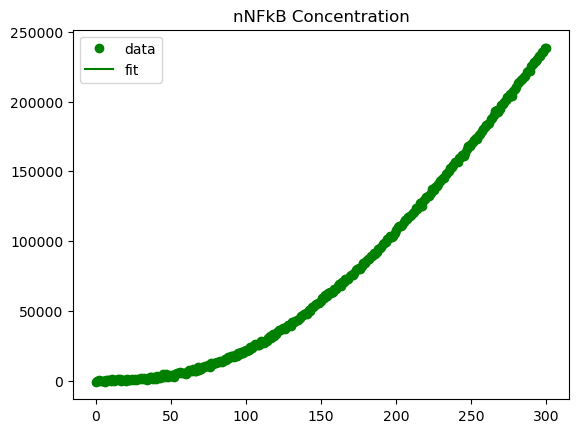

In [8]:
traj= model.run(params=model.p_true,output=list(model.data.columns))
plt.plot(model.data['time'].values,model.data['nNFkB'].values,'go',label='data')
plt.plot(traj[:,0],traj[:,1],'g-',label='fit')
_=plt.legend()
plt.title("nNFkB Concentration")

In [9]:
# function to plot model fit 
def plot_fit(p):
    # simulates model with parameters over specific time frame
    ## traj has time and conentration 
    traj= model.run(params=p,times=np.linspace(0,300,301))
    # plots experimental data 
    plt.plot(model.data['time'].values,model.data['nNFkB'].values,'go',label='data')
    # plots model fit 
    plt.plot(traj[:,0],traj[:,1],'g-',label='fit')
    # log likelihood to calc cost of the fit 
    cost= model.log_likelihood(p)
    plt.title(f'Fit for $\chi^2=${-cost:0.2e}')
    _=plt.legend()

In [10]:
# use to find best param values (minimizes chi-square)
from scipy.optimize import minimize, fsolve
# 
chisq= lambda p: -model.log_likelihood(p)
# x0 is guess for params 
# bf = minimize(chisq, x0=[0.0352,-3.0688,-4.5164,-7.4173,-2.057,-5.9334,-8,-7.3178,-4.1089,-10.6289,-3.5859,-4.6363,-4.6,-3.2082,-7,-8,-20,-20,-20,-20,2.5258,4.7454,6.5546], method='nelder-mead',options={'maxiter':1000})

bf = minimize(chisq, x0=[0.0352,-3.0688,-4.5164,-7.4173,-2.057,-5.9334,-8,-7.3178], method='nelder-mead',options={'maxiter':1000})

print(bf)

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 161998795.43503982
             x: [-1.914e-01 -3.745e+00 -4.533e+00 -7.253e+01 -2.060e+00
                 -3.307e+00 -7.976e+00 -1.490e+01]
           nit: 1000
          nfev: 1496
 final_simplex: (array([[-1.914e-01, -3.745e+00, ..., -7.976e+00,
                        -1.490e+01],
                       [-1.891e-01, -3.712e+00, ..., -7.976e+00,
                        -1.485e+01],
                       ...,
                       [-1.881e-01, -3.699e+00, ..., -7.977e+00,
                        -1.483e+01],
                       [-1.888e-01, -3.710e+00, ..., -7.976e+00,
                        -1.484e+01]]), array([ 1.620e+08,  1.620e+08,  1.620e+08,  1.620e+08,
                        1.620e+08,  1.620e+08,  1.620e+08,  1.620e+08,
                        1.620e+08]))


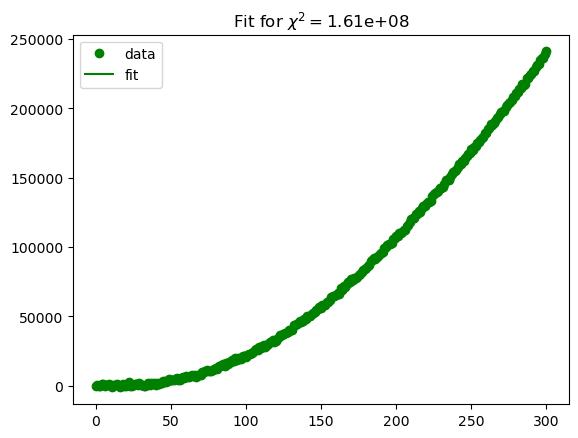

In [10]:
plot_fit(bf.x)

In [12]:
n_particles = 1000
# Initialise particles' positions using samples from the prior 
sampler = qmc.LatinHypercube(d=model.n_params, seed=SEED)
sample = sampler.random(n=n_particles) 
print("The discrepancy of the sampling (i.e., sample quality): %.4f"%qmc.discrepancy(sample)) #discrepancy is distance between cont. uniform distr. on hypercube & discr. uniform distr. on n distinct sample points
prior_samples = qmc.scale(sample, l_bounds=model.lower_bnds, u_bounds=model.upper_bnds)
print(prior_samples.shape)

The discrepancy of the sampling (i.e., sample quality): 0.0002


ValueError: 'l_bounds' and 'u_bounds' must be broadcastable and respect the sample dimension

In [18]:
t0 = time.time() #stores current time, date, year, etc. in one float
# with Pool(n_cpus) as pool: #sets up code to run over my n number of cpus on laptop
    
sampler = pc.Sampler(n_particles = n_particles,
                n_dim = model.n_params,
                log_likelihood = model.log_likelihood,
                log_prior = model.log_prior,
                bounds = np.array(list(zip(model.lower_bnds, model.upper_bnds))),
                random_state=SEED,
                vectorize_likelihood=False,
                vectorize_prior=False,
                infer_vectorization=False
            ) #stores all relevant info from # of parameters being fit (ndim) to the actual results

sampler.run(prior_samples = prior_samples) #starts with prior sample definied in latin hypercube sampling, and runs it
result = sampler.results #results of sampler.run on prior_samples

with open('tester01_result.pkl', 'wb') as f: #open that file if exists, if not make that file
    pickle.dump(result, f, protocol=pickle.HIGHEST_PROTOCOL) #saves result object (dictionary) to pickle file

# we need to remove the librr simulator from the class in order to successfully save and load the class from a pkl file. 
#del model.rr
with open('tester01_mod.pkl', 'wb') as f: #open that file if exists, if not make that file
    pickle.dump(model.__dict__, f, protocol=pickle.HIGHEST_PROTOCOL) #saves model dictionary in pickle file

t1 = time.time() #time after running this section
seconds = t1-t0 #difference in start and stop time

elapsed = time.strftime("%H:%M:%S", time.gmtime(seconds)) #converts float to a time quantity we use
print('\nElapsed time: ', elapsed) #printing time it took for code to run

ValueError: Expected input to have dtype float, but got int64

In [26]:
pc.plotting.trace(result, labels=model.params);

NameError: name 'result' is not defined